In [1]:
cd "nilm data\ukdale"

D:\jjenko\nilm data\ukdale


In [2]:
from nilmtk import DataSet
from nilmtk.utils import print_dict

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nilmtk
from nilmtk import DataSet, MeterGroup

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 10)
plt.figure(figsize=(10,30))

ukdale = DataSet('ukdale.h5')
ukdale.set_window(start='2013-3-15T1127',end='2013-4-20T1200')


<Figure size 720x2160 with 0 Axes>

C:\Users\jjenko\anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


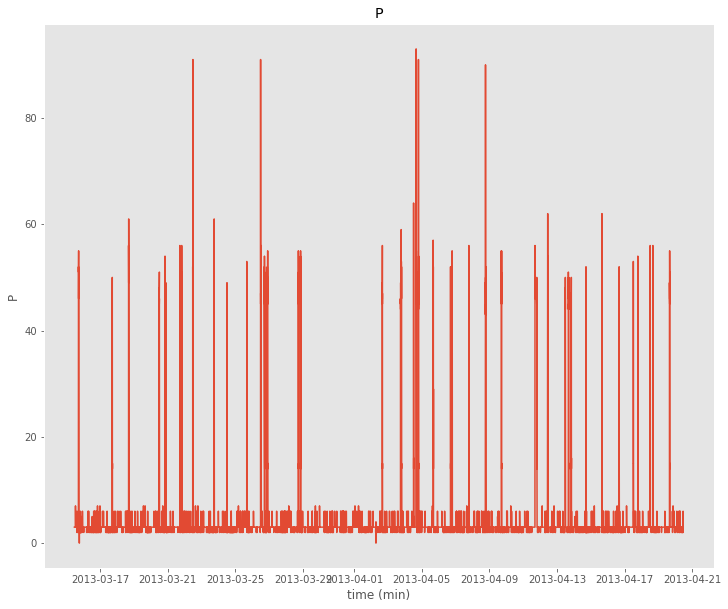

In [3]:
elec = ukdale.buildings[1].elec
fridge = elec['oven']
fridge.available_columns()
df = next(fridge.load(physical_quantity='power'))

fig, ax = plt.subplots()
ax.plot(df.fillna(0))
ax.set(xlabel='time (min)', ylabel='P', title='P')
ax.grid()

#df.power.active[1900:1950]

In [4]:
df.axes

[DatetimeIndex(['2013-03-15 11:27:00+00:00', '2013-03-15 11:27:07+00:00',
                '2013-03-15 11:27:14+00:00', '2013-03-15 11:27:21+00:00',
                '2013-03-15 11:27:27+00:00', '2013-03-15 11:27:34+00:00',
                '2013-03-15 11:27:41+00:00', '2013-03-15 11:27:48+00:00',
                '2013-03-15 11:27:54+00:00', '2013-03-15 11:28:01+00:00',
                ...
                '2013-04-20 11:59:01+01:00', '2013-04-20 11:59:08+01:00',
                '2013-04-20 11:59:15+01:00', '2013-04-20 11:59:22+01:00',
                '2013-04-20 11:59:28+01:00', '2013-04-20 11:59:34+01:00',
                '2013-04-20 11:59:40+01:00', '2013-04-20 11:59:46+01:00',
                '2013-04-20 11:59:52+01:00', '2013-04-20 11:59:58+01:00'],
               dtype='datetime64[ns, Europe/London]', length=448017, freq=None),
 MultiIndex([('power', 'active')],
            names=['physical_quantity', 'type'])]

In [5]:
values = df.power.values
allZeros = np.all(values==0)
print(allZeros)


False


In [7]:
#cell is responsible for storing and handling with hdf5 data
import h5py

#if file does not exist create new one (M-n of months A-n of appliances)
#file_name = "UKDALE_GAF_1h_12M10A300N"
file_name = "UKDALE_GAF_10m_100S10X_10A300N" # x is n of paralel imgs

#check if file exists
try:
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5","r")
    print("file exists!")
    file.close()

except:
    print("creating new file! ...")
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "w")
    file.close()

def create_hdf5_group(group_name): #groups are appliances such as fridge or toaster

    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    dataset = file.create_group(f"{group_name}")
    file.close()


def store_single_hdf5(image, image_id, group_name): 
    """
    Stores single image to HDF5
    """     
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    group = file[f"{group_name}"]
    
    # Create a dataset in the file
    #"image", np.shape(image), h5py.h5t.STD_U8BE, data=image -> def guts
    dataset = g.create_dataset(f"{image_id}",np.shape(image))
        
   
    file.close()

def store_many_hdf5(images,group_name,image_set_name,**kwargs):
    """
    Stores multiple images to HDF5
    **kwargs(force_del="yes" to replace existing db w/o prompt)
    """     
    #define some parameters
    num_images = len(images)
    force_del_flag = kwargs.get('force_del', None)# we need it, if "store many" is frequent
    
    label_flag = kwargs.get('labels', None)# we need it, if "store many" is frequent

    # read HDF5 file
    try:
        file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    except:
        print("file not found!")
    
    
    # open specified group
    try:
        group = file[f"{group_name}"]
    except:
        #if if does not exist create it
        group = file.create_group(f"{group_name}")
        

    #check if ds already exists, then prompt user
    for name in group:
        if str(name) == str(image_set_name):
            if force_del_flag == "yes":
                print("  removed "f"{name}""!")   
                del group[name]
            else:
                print("Dataset '"f"{name}" "' already exists in " f"{file_name}""/"f"{group_name}")
                
                ans = input("Do you want to replace existing dataset? (y,n) Press enter to contine")
                    
                if ans == "y":
                    print("  removed "f"{name}""!")   
                    del group[name]
                else:
                    print("  quiting! ") 
                    raise

    # Create a dataset in the group       
    print("storing... images to store: "f"{num_images}")
    
    if label_flag == True:
        #save labels as integers. If sentence needed in case no labels are provided
        dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.H5T_STD_I8BE , data=images)
    else:
        dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.IEEE_F32LE , data=images)
    
    file.close()
    print("finshed. stored to " f"{file_name}""/"f"{group_name}""/"f"{image_set_name}")


def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.

    """
    images = []


    # Open the HDF5 file
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

creating new file! ...


In [6]:
#create new ds inside
#create_hdf5_group("fridge")
#store_many_hdf5(gasf_stack,"fridge","gasf")


In [9]:
#next 3 cells generate GAFs on based on manual selecont of interval
#select time range and period
#was working for hourly data--
# step_in_hrs = 1
# date_range = pd.date_range("2013-1-10T0000", "2014-1-1T0000",freq=''+str(step_in_hrs)+'h')
#----------
step_in_mins = 12
date_range = pd.date_range("2013-1-10T0000", "2014-10-20T0000",freq=f'{step_in_mins}''T')
#print(date_range)

In [ ]:
#(debug)graph first portion of the seleted range
# n = 18
# ukdale.set_window(start=date_range[n],end=date_range[n+1])
# elec = ukdale.buildings[1].elec
# fridge = elec['fridge']
# fridge.available_columns()
# df = next(fridge.load(physical_quantity='power'))
# print(len(df))
# fig, ax = plt.subplots()
# ax.plot(df)
# ax.set(xlabel='time (min)', ylabel='P', title='P')
# ax.grid()


In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
import numpy as np
import h5py

#--PARAMTERS--#
max_dataset_size = 300; #max number of images per appliance
img_size = 100; # means img_size x img_size

#change to 0 for normal images
n_of_multi_dim_imgs = 10

manualy_selected_appliances = ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","oven","boiler","toaster","kettle","fridge"]

#manualy_selected_appliances = ["washer dryer", "microwave","televison"]
#usefull_appliances = manualy_selected_appliances.copy()

#main parameters - these are arrays that will hold all of the appended data
gasf_stack_main = np.empty([0,n_of_multi_dim_imgs,img_size,img_size])
label_stack = np.empty(0)


#main idea is to loop through all of the applianes and collect at least N of "max_dataset_size" images for each one
for appliance in manualy_selected_appliances:
    print("\n")
    print("starting "f"{appliance} ("+str(manualy_selected_appliances.index(appliance)+1)+"/"+str(len(manualy_selected_appliances))+"):")
    
    #define some of the paramteres mainly for creating stack of images
    N_of_dates = len(date_range)-2


    #check if user wants mutli 
    if n_of_multi_dim_imgs != 0:
        gasf_stack_tmp = np.empty([0,img_size,img_size])
        gasf_stack = np.empty([0,n_of_multi_dim_imgs,img_size,img_size])
        gadf_stack = np.empty([0,n_of_multi_dim_imgs,img_size,img_size])

    else:
        gasf_stack = np.empty([0,img_size,img_size])
        gadf_stack = np.empty([0,img_size,img_size])
    
    for interval in range(N_of_dates):

        try:
            ukdale.set_window(start=date_range[interval],end=date_range[interval+1])
        except:
            continue

        #try to read from dataset
        try:
            elec = ukdale.buildings[1].elec
            appliance_data = elec[appliance]
            #appliance_data.available_columns()
            df = next(appliance_data.load(physical_quantity='power'))
        except:
            #uncomment fo debug
            #print("problem, no data for "+appliance+"!")
            continue

        #do some metric calcs in order to determine if selected window needs to be dropped
        metric = (60*step_in_mins)/6 #will adjust automaticly
        if len(df) < 0.88*metric:# -> manulay select %
            #uncomment for debug
            #if len(df) != 0:
            #print("skipped: "+str(date_range[interval])+" had only "+str(len(df))+" out of "+str(metric)+" points ("+str(int(100*(len(df))/metric))+"%)")
            continue 
        
        #check if all values in an array are equal to 0
        values = df.power.values
        All_zero = np.all(values==0)  
        All_ones = np.all(values==1)  
        All_equal = np.all(values==values[0])
        if All_zero == True or All_ones == True or All_equal == True:
            #print("skipped due all zero or all one")
            #if all values are 0 then skip
            continue

        #check if dataset size is larger than specified
        if gasf_stack.shape[0] >= max_dataset_size:
            print("max DS size reached size of "f"{max_dataset_size}"", skipping!")   
            break

        #do some reshaping to satisfy GAF library
        S = df.fillna(0).to_numpy().reshape(1,-1)
        Ssmall= S[0,0:S.size]
        S2d = np.reshape(Ssmall, (1, S.size))

        # Transform the time series into Gramian Angular Fields
        gasf = GramianAngularField(image_size=img_size, method='summation')
        X_gasf = gasf.fit_transform(S2d)
        #gadf = GramianAngularField(image_size=img_size, method='difference')
        #X_gadf = gadf.fit_transform(S2d)
        
        #part where we save converted images
        if len(gasf_stack.shape) == 4:

            #append as multi dimensonal images 
            if gasf_stack_tmp.shape[0] < n_of_multi_dim_imgs:
                gasf_stack_tmp = np.append(gasf_stack_tmp,X_gasf,axis=0)
            else:
                gasf_stack_tmp = gasf_stack_tmp[np.newaxis, ...] #add new axis for compatability
                gasf_stack = np.append(gasf_stack,gasf_stack_tmp,axis=0)
                label_stack = np.append(label_stack,int(f"{manualy_selected_appliances.index(appliance)}"))
                gasf_stack_tmp = np.empty([0,img_size,img_size])
        else:
            #append as ordinary images
            gasf_stack = np.append(gasf_stack,X_gasf,axis=0)
            label_stack = np.append(label_stack,int(f"{manualy_selected_appliances.index(appliance)}"))
            
        
        print("\r",round(100*interval/(N_of_dates-1),2)," % complete         ",end="")

    print("")
    print("number of images (per dataset) stacked: "f"{gasf_stack.shape[0]}"" out of all possible " f"{N_of_dates}" " ("f"{int(100*gasf_stack.shape[0]/N_of_dates)}""%)")
    
    
    gasf_stack_main = np.append(gasf_stack_main,gasf_stack,axis=0)
    # if gasf_stack.shape[0] > 0:
    #     store_many_hdf5(gasf_stack,f"{appliance}","gasf",force_del="yes")
    #     #store_many_hdf5(label_stack,f"{appliance}","label",force_del="yes")
    # else:
    #     usefull_appliances.remove(appliance)
    #     print("nothing to store!")
    
    print("finished "f"{appliance}")
    
    print("\n")

gasf_stack_main = gasf_stack_main[...,np.newaxis]
store_many_hdf5(gasf_stack_main,"data","gasf",force_del="yes")
store_many_hdf5(label_stack,"labels","gaf",force_del="yes",label=True)



starting computer monitor (1/10):
 4.58  % complete         

KeyboardInterrupt: 

In [43]:
gasf_stack_main = np.append(gasf_stack_main,gasf_stack,axis=0)

In [9]:
file.close()

In [ ]:
manualy_selected_appliances = ["computer monitor", "laptop computer", "televison", "washer dryer", "microwave","oven","boiler","toaster","kettle"]
usefull_appliances = manualy_selected_appliances.copy()
usefull_appliances.remove("televison")
print(usefull_appliances)

In [ ]:
# Show image to be saved
fig, ax = plt.subplots()
ax.imshow(gasf_stack[129], cmap='rainbow')
gasf_stack[129][50][50]

In [ ]:
#store images generated above
store_many_hdf5(gasf_stack,"fridge","gasf")

In [3]:
#retrieve stored images
ret_imgs = read_many_hdf5("data","gasf")
ret_labels =  read_many_hdf5("labels","gaf")
ret_imgs.shape


NameError: name 'read_many_hdf5' is not defined

microwave


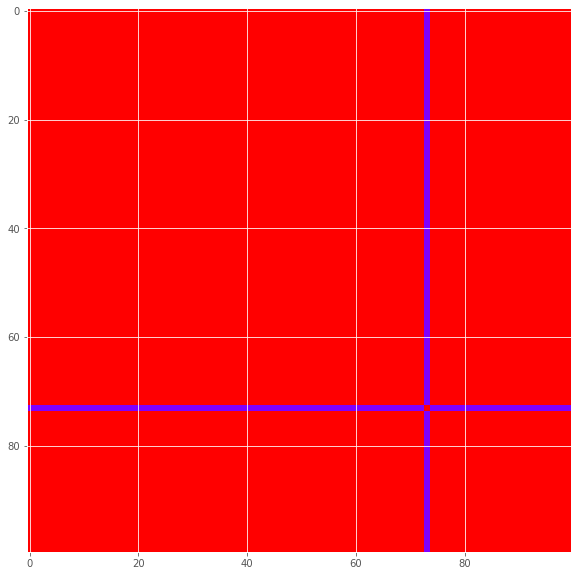

In [57]:
# Show retrieved image
someN = 29
fig, ax = plt.subplots()
ax.imshow(ret_imgs[someN,3,...,0], cmap='rainbow')
print(manualy_selected_appliances[int(ret_labels[someN])])
# ax.imshow(ret_img_stack[3,1], cmap='rainbow')
# ax.imshow(ret_img_stack[5,3], cmap='rainbow')



(20, 10, 100, 100)

In [ ]:
appl = elec.appliances
num_of_appliances = len(appl)
import time
manualy_selected_appliances = ["computer", "computer monitor", "laptop computer", "televison", "washer dryer", "coffee maker", "microwave" ]

# for appliance in manualy_selected_appliances:
 
#  try:
#     applianceD = elec[appliance]
#  except:
#     #print("problem")
#     continue
#  time.sleep(1)
#  print("\r",100*manualy_selected_appliances.index(appliance)/(len(manualy_selected_appliances)-1)," percent complete         ",end="")


#select window and check quality of data in the window
ukdale.set_window(start='2013-1-8T0920',end='2013-3-1T1200')


for i in range(num_of_appliances):

   appl[i] = appl[i].type["type"]

   try:
      elec = ukdale.buildings[1].elec
      appliance_data = elec[appl[i]]
      #appliance_data.available_columns()
      df = next(appliance_data.load(physical_quantity='power'))
   except:
      print("problem, no data for "+appliance+"!")
      continue
   print(appl[i]) 

In [ ]:
file.close()